In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


from Models.ARIMA import *
from Models.Misc import *
from Data import *
from Models.MLP import *
from Models.Hybrid import *

# Entry point for the notebook:
## To run the system on a new data set, the file name in load_data() should be changed accordingly. 



In [3]:
# 10 year ETF
IBB = Path.cwd() / "data" / "IBB.csv"

# 5 year ETF
ARKK = Path.cwd() / "data" / "ARKK.csv"

# 1 year ETF
ARKQ = Path.cwd() / "data" / "ARKQ.csv"


data_close = load_data(ARKQ)

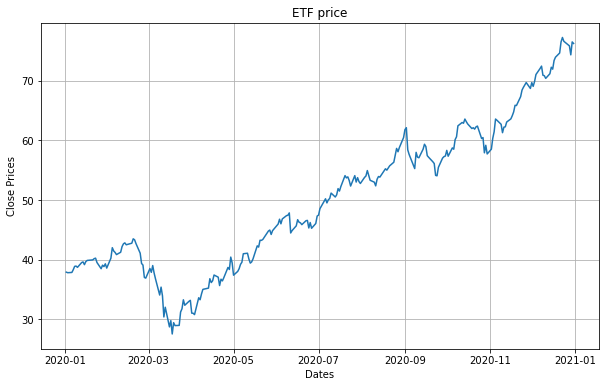

In [4]:
#Plot of closing prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data_close['Close'])
plt.title('ETF price')
plt.show()

Number of values above 0.9 autocorrelation is:  9


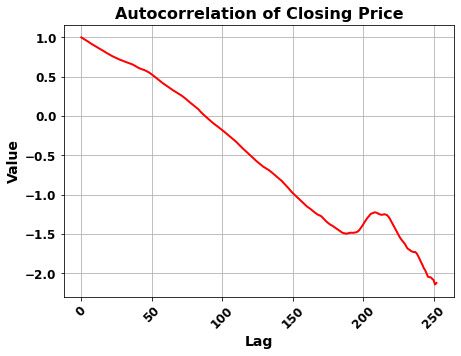

In [5]:
input_dim = find_input_dim(data_close['Close'])

In [6]:
data_copy = data_close.copy()

train_data, test_data = train_test_split(data_copy.iloc[input_dim:], test_size=0.10, shuffle = False)

print(train_data)

                Close
Date                 
2020-01-15  39.151001
2020-01-16  39.669998
2020-01-17  39.860001
2020-01-21  39.950001
2020-01-22  40.160000
...               ...
2020-11-18  64.800003
2020-11-19  65.910004
2020-11-20  65.870003
2020-11-23  67.360001
2020-11-24  68.459999

[219 rows x 1 columns]


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=672.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=673.479, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=673.848, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=674.051, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=673.158, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.105 seconds


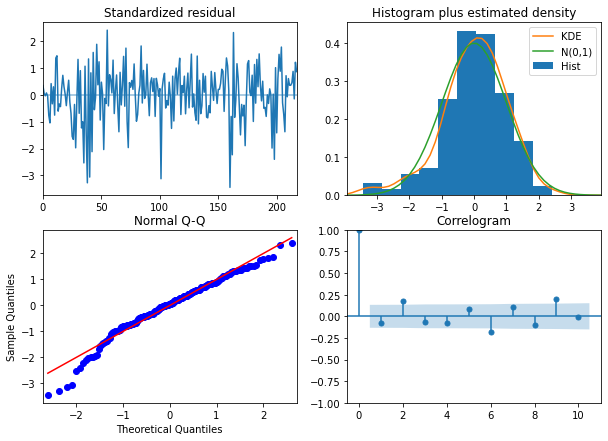

In [7]:
arima_model_order =  auto_arima(train_data,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, test='kpss', seasonal_test='ocsb', error_action='warn',
                          trace = True, supress_warnings=True,stepwise = True,
                          random_state=None, n_fits = 50)

arima_model_order.plot_diagnostics(figsize=(10,7))
plt.show()

C:\Users\Andu\anaconda3\envs\Tensorflow\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Andu\anaconda3\envs\Tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but 

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  218
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -334.472
Method:                           css   S.D. of innovations              1.122
Date:                Sun, 08 Aug 2021   AIC                            672.945
Time:                        15:38:43   BIC                            679.714
Sample:                             1   HQIC                           675.679
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1344      0.076      1.769      0.077      -0.015       0.283


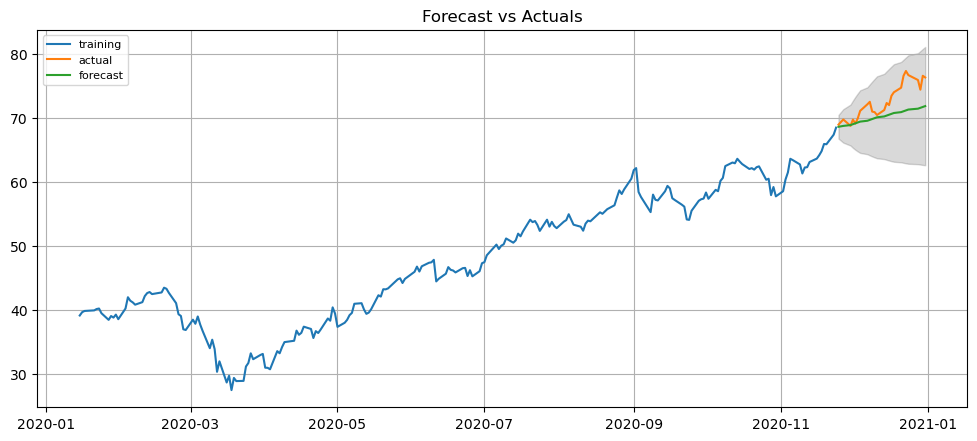

In [8]:
fc = ARIMA_pred(train_data, test_data, arima_model_order.order)

In [9]:
print("Error measures for ARIMA:")
calculate_error_measures(test_data, fc)

Error measures for ARIMA:
Mean Squared Error:  9.231111922419498
Mean Absolute Error:  2.415862360367009


[9.231111922419498, 2.415862360367009]

# MLP

In [10]:
columns_mlp = ['Close']

n_lags_mlp = []
for i in range(1, input_dim+1):
    n_lags_mlp.append(i)

df_new = create_regressor_attributes(data_close, columns_mlp, n_lags_mlp)

df_new.shape

(244, 10)

In [11]:
df_new.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5),Close_(t-6),Close_(t-7),Close_(t-8),Close_(t-9)
datetime,,,,,,,,,,
2020-01-15,39.151001,39.610001,39.500000,38.700001,38.910000,38.869999,38.310001,37.842999,37.797001,37.891998
2020-01-16,39.669998,39.151001,39.610001,39.500000,38.700001,38.910000,38.869999,38.310001,37.842999,37.797001
2020-01-17,39.860001,39.669998,39.151001,39.610001,39.500000,38.700001,38.910000,38.869999,38.310001,37.842999
2020-01-21,39.950001,39.860001,39.669998,39.151001,39.610001,39.500000,38.700001,38.910000,38.869999,38.310001
2020-01-22,40.160000,39.950001,39.860001,39.669998,39.151001,39.610001,39.500000,38.700001,38.910000,38.869999


In [12]:
X_train, y_train, X_valid, y_valid, X_test, y_test = create_train_valid_test(df_new, 0.10, 0.10)


Shape of training inputs, training target: (197, 9) (197,)
Shape of validation inputs, validation target: (22, 9) (22,)
Shape of test inputs, test target: (25, 9) (25,)


In [13]:
scaler = MinMaxScaler()

X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled = scale_data(
    X_train, y_train, X_valid, y_valid, X_test, y_test, scaler)


In [14]:
y_test_rescaled = scaler.inverse_transform(y_test_scaled)


In [15]:
baseline_test(10, input_dim, X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_rescaled, scaler)

[INFO] training model...
Mean Squared Error:  13.118654009179982
Mean Absolute Error:  2.8112148178125
[INFO] training model...
Mean Squared Error:  2.8520662161976573
Mean Absolute Error:  1.4560006888281276
[INFO] training model...
Mean Squared Error:  3.4849509649290473
Mean Absolute Error:  1.5547161727929693
[INFO] training model...
Mean Squared Error:  2.324286986688795
Mean Absolute Error:  1.2908975394140652
[INFO] training model...
Mean Squared Error:  2.317685088223578
Mean Absolute Error:  1.2157883233203126
[INFO] training model...
Mean Squared Error:  1.309900222184036
Mean Absolute Error:  0.8586187715820318
[INFO] training model...
Mean Squared Error:  13.116641602620204
Mean Absolute Error:  2.810996617128906
[INFO] training model...
Mean Squared Error:  2.312843062840866
Mean Absolute Error:  1.2100033458203114
[INFO] training model...
Mean Squared Error:  3.223340373008386
Mean Absolute Error:  1.542304437695313
[INFO] training model...
Mean Squared Error:  5.28576007

(4.934612860160356, 1.6605370808652347)

In [16]:
# wrap model into a scikit-learn compatible regressor
model = KerasRegressor(build_fn=get_mlp_model, verbose=0, input_dim=input_dim)
# define a grid of the hyperparameter search space
hidden_layer_one = [25, 50, 100]
hidden_layer_two = [5, 10, 25]
learn_rate = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2 , 0.3, 0.4, 0.5]
batch_size = [4, 8, 16, 32, 64, 128]
epochs = [10, 50, 100, 500, 1000]
# create a dictionary from the hyperparameter grid
grid = dict(
    hidden_layer_one=hidden_layer_one,
    hidden_layer_two=hidden_layer_two,
    dropout=dropout,
    learn_rate=learn_rate,
    batch_size=batch_size,
    epochs=epochs
)


In [17]:
best_parameters = optimize_parameters(model, grid, X_train_scaled, y_train_scaled)


hidden_layer_one=best_parameters['hidden_layer_one']
hidden_layer_two=best_parameters['hidden_layer_two']
dropout=best_parameters['dropout']
learn_rate=best_parameters['learn_rate']
batch_size=best_parameters['batch_size']
epochs=best_parameters['epochs']


best_model = get_mlp_model(input_dim, hidden_layer_one=hidden_layer_one, hidden_layer_two=hidden_layer_two,
    dropout=dropout, learn_rate=learn_rate)



[INFO] performing random search...
Best parameters are: {'learn_rate': 0.001, 'hidden_layer_two': 10, 'hidden_layer_one': 100, 'epochs': 500, 'dropout': 0.3, 'batch_size': 8}


In [18]:
#
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 0, patience = 25, verbose=1, restore_best_weights=True)


history = best_model.fit(x=X_train_scaled, y=y_train_scaled,
    validation_data=(X_valid_scaled, y_valid_scaled),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=es,
    shuffle=False,
    verbose=False)

MLP_pred = best_model.predict(X_test_scaled)
MLP_pred_rescaled = scaler.inverse_transform(MLP_pred)






Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping


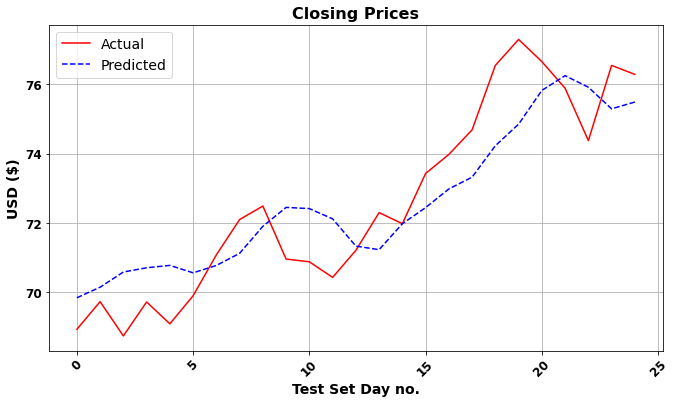

Error measures for MLP:
Mean Squared Error:  1.5700667621472975
Mean Absolute Error:  1.0876001203320305


[1.5700667621472975, 1.0876001203320305]

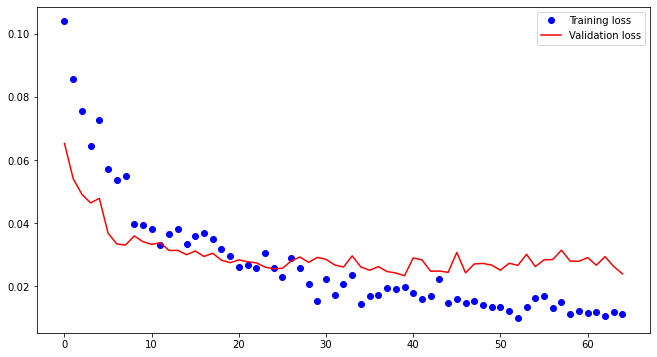

In [19]:
plot_comparison_graph(y_test_rescaled, MLP_pred_rescaled)
plot_loss(history)

print("Error measures for MLP:")
calculate_error_measures(y_test_rescaled, MLP_pred_rescaled)

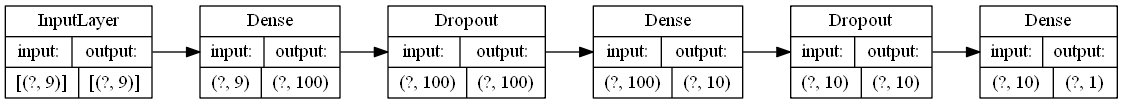

In [20]:
plot_model(best_model,
    to_file="Reports/MLP.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=96)

# Hybrid

In [21]:
train_data2, test_data2 = train_test_split(data_copy, test_size=0.50, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=387.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=386.721, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=387.311, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=385.897, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=387.736, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.069 seconds


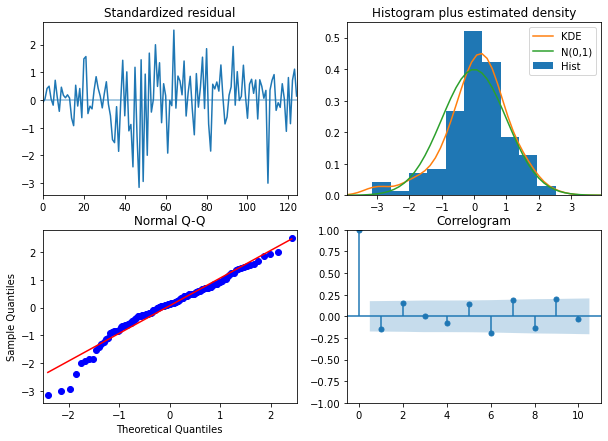

In [22]:
arima_model_order2 =  auto_arima(train_data2,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, test='kpss', seasonal_test='ocsb', error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=None, n_fits = 50)

arima_model_order2.plot_diagnostics(figsize=(10,7))
plt.show()

C:\Users\Andu\anaconda3\envs\Tensorflow\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Andu\anaconda3\envs\Tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but 

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  125
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -191.657
Method:                           css   S.D. of innovations              1.121
Date:                Sun, 08 Aug 2021   AIC                            387.314
Time:                        15:39:34   BIC                            392.971
Sample:                             1   HQIC                           389.612
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0766      0.100      0.764      0.445      -0.120       0.273


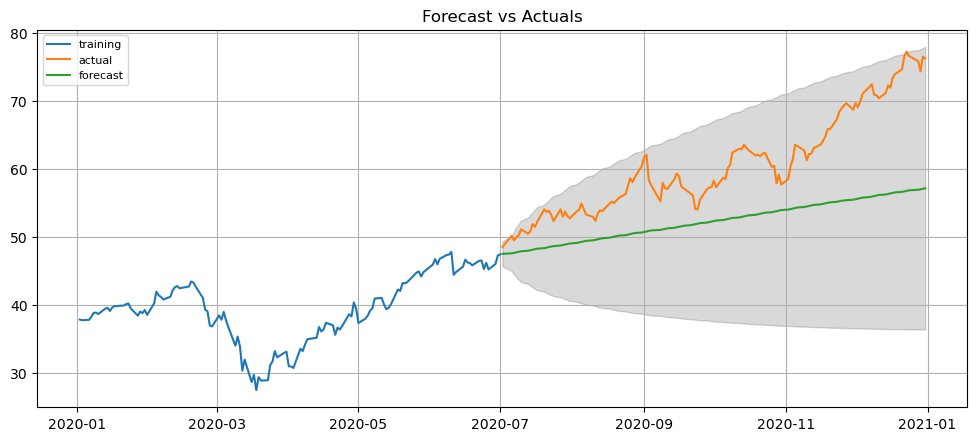

In [23]:
fc_resid = ARIMA_pred(train_data2, test_data2, arima_model_order2.order)

residuals = [a-b for a,b in zip(test_data2['Close'], fc_resid)]

resid = pd.DataFrame(residuals, columns = ['resid'])

Number of values above 0.9 autocorrelation is:  3


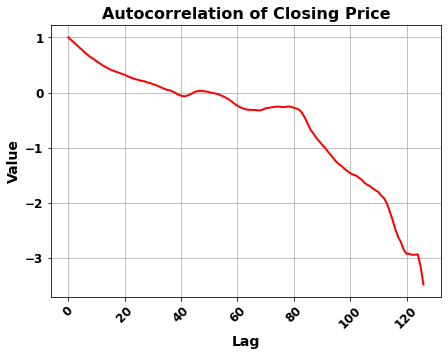

In [24]:
input_dim_hybrid = find_input_dim(resid['resid'])

In [25]:
column_hybrid = ['resid']

n_lags_hybrid = []
for i in range(1, input_dim_hybrid+1):
    n_lags_hybrid.append(i)

df_new_hybrid = create_regressor_attributes(resid, column_hybrid, n_lags_hybrid)

In [26]:
X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = create_train_valid_test(
    df_new_hybrid, 0.20, 0.10)


X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = scale_data(
    X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid, scaler)


Shape of training inputs, training target: (89, 3) (89,)
Shape of validation inputs, validation target: (10, 3) (10,)
Shape of test inputs, test target: (25, 3) (25,)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


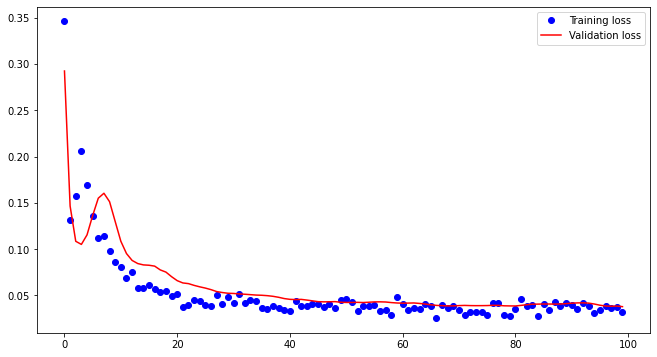

In [27]:
resid_HMLP, history_hybrid = forecast_HMLP_residuals(
    input_dim_hybrid, X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid)

resid_HMLP = scaler.inverse_transform(resid_HMLP)


plot_loss(history_hybrid)


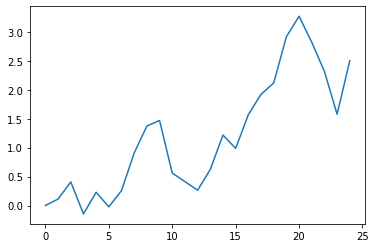

In [28]:
resid_HMLP = zero_centre(resid_HMLP)

plt.plot(resid_HMLP)
plt.show()

In [29]:
#List comprehension to combine ARIMA and HMLP forecast.
pred_hybrid = [a+b for a,b in zip(fc, resid_HMLP)]

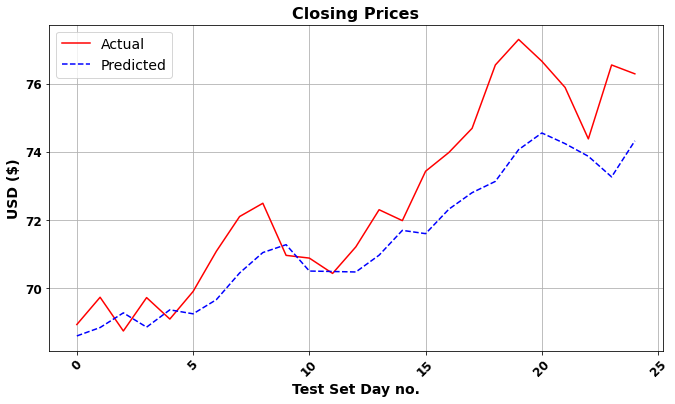

Error measures for Hybrid:
Mean Squared Error:  2.636414458870507
Mean Absolute Error:  1.3099831268359372


[2.636414458870507, 1.3099831268359372]

In [30]:
y_test_rescaled, pred_hybrid = equal_size(y_test_rescaled, pred_hybrid)

plot_comparison_graph(y_test_rescaled, pred_hybrid)

print("Error measures for Hybrid:")
calculate_error_measures(y_test_rescaled, pred_hybrid)